In [1]:
import numpy as np
import pickle
import cv2
import glob
import time
from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scipy.ndimage.measurements import label
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [2]:
cars = glob.glob('vehicles/**/*.png')
notcars = glob.glob('non-vehicles/**/*.png')
print('Number of Vehicle Images:',len(cars))
print('Number of Non-Vehicle Images:',len(notcars))

Number of Vehicle Images: 8792
Number of Non-Vehicle Images: 8968


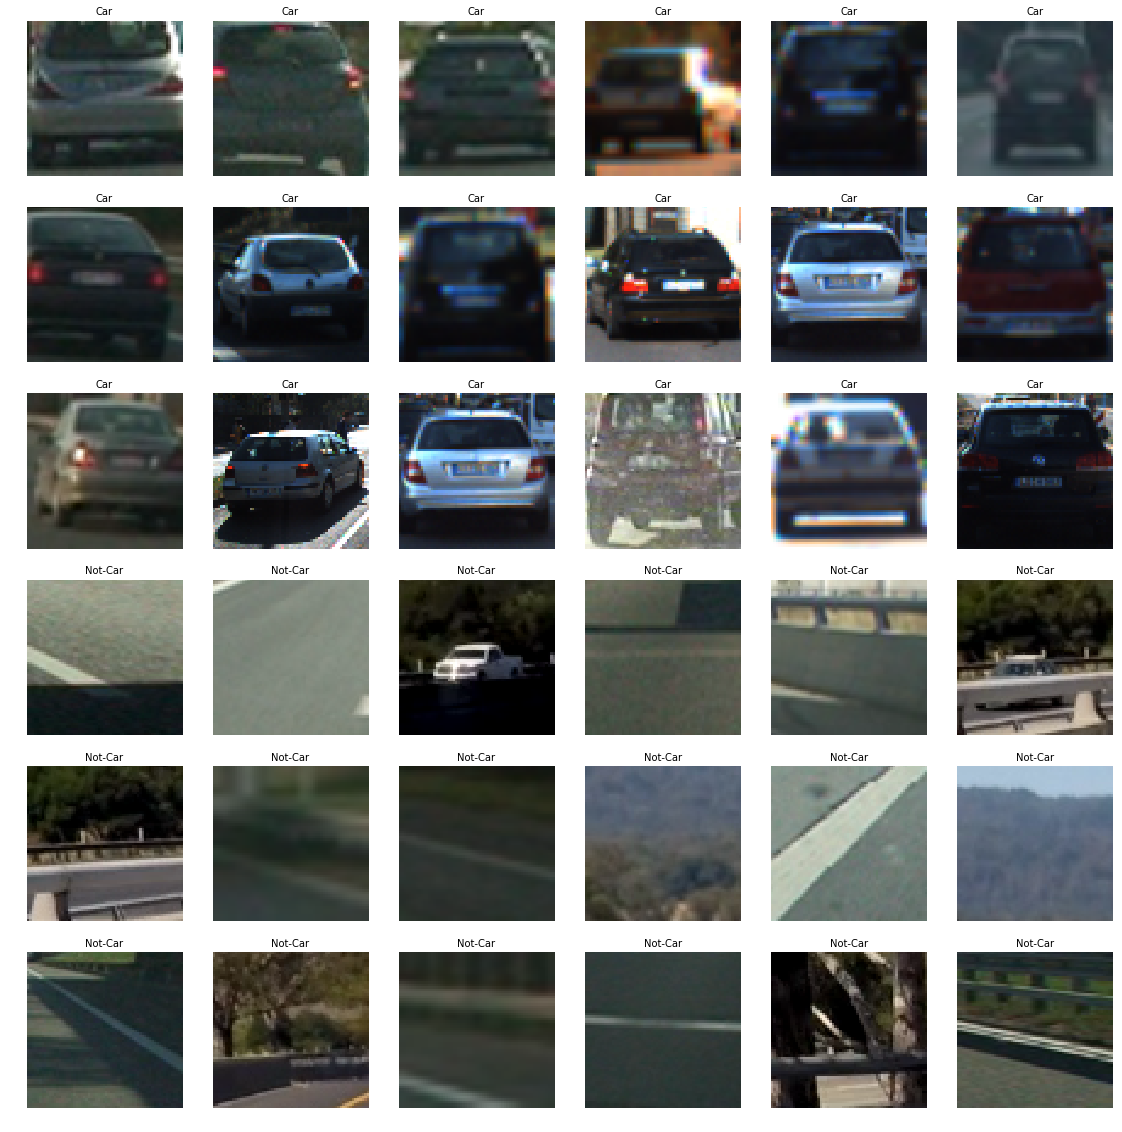

In [3]:
fig, axes = plt.subplots(6,6, figsize=(20,20))
fig.subplots_adjust(hspace = .2, wspace=.001)
axes = axes.ravel()


for i in np.arange(18):
    img = cv2.imread(cars[np.random.randint(0,len(cars))])
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    axes[i].axis('off')
    axes[i].set_title('Car', fontsize=10)
    axes[i].imshow(img)
for i in np.arange(18,36):
    img = cv2.imread(notcars[np.random.randint(0,len(notcars))])
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    axes[i].axis('off')
    axes[i].set_title('Not-Car', fontsize=10)
    axes[i].imshow(img)

In [4]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):

    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features
    
    
def extract_features(imgs, cspace='RGB', orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0):

    features = []

    for file in imgs:
    
        image = mpimg.imread(file)
    
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

    
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        
        features.append(hog_features)
   
    return features



def find_cars(img, ystart, ystop, scale, cspace, hog_channel, svc, X_scaler, orient, 
              pix_per_cell, cell_per_block, spatial_size, hist_bins, show_all_rectangles=False):
    
    draw_img=np.copy(img)
    boxes=[]
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]


    if cspace != 'RGB':
        if cspace == 'HSV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YUV)
        elif cspace == 'YCrCb':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YCrCb)
    else: ctrans_tosearch = np.copy(image)   
    
   
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
    
    # select colorspace channel for HOG 
    if hog_channel == 'ALL':
        ch1 = ctrans_tosearch[:,:,0]
        ch2 = ctrans_tosearch[:,:,1]
        ch3 = ctrans_tosearch[:,:,2]
    else: 
        ch1 = ctrans_tosearch[:,:,hog_channel]

    
    nxblocks = (ch1.shape[1] // pix_per_cell)+1  #-1
    nyblocks = (ch1.shape[0] // pix_per_cell)+1  #-1 
    nfeat_per_block = orient*cell_per_block**2
    
    window = 64
    nblocks_per_window = (window // pix_per_cell)-1 
    cells_per_step = 2
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
   
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)   
    if hog_channel == 'ALL':
        hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
           
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            if hog_channel == 'ALL':
                hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            else:
                hog_features = hog_feat1

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell
            
            test_prediction = svc.predict(hog_features.reshape(1,-1))
            
            if test_prediction == 1 or show_all_rectangles:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,255,0),6) 
                boxes.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                
    return draw_img,boxes

Text(0.5,1,'Not Car HOG')

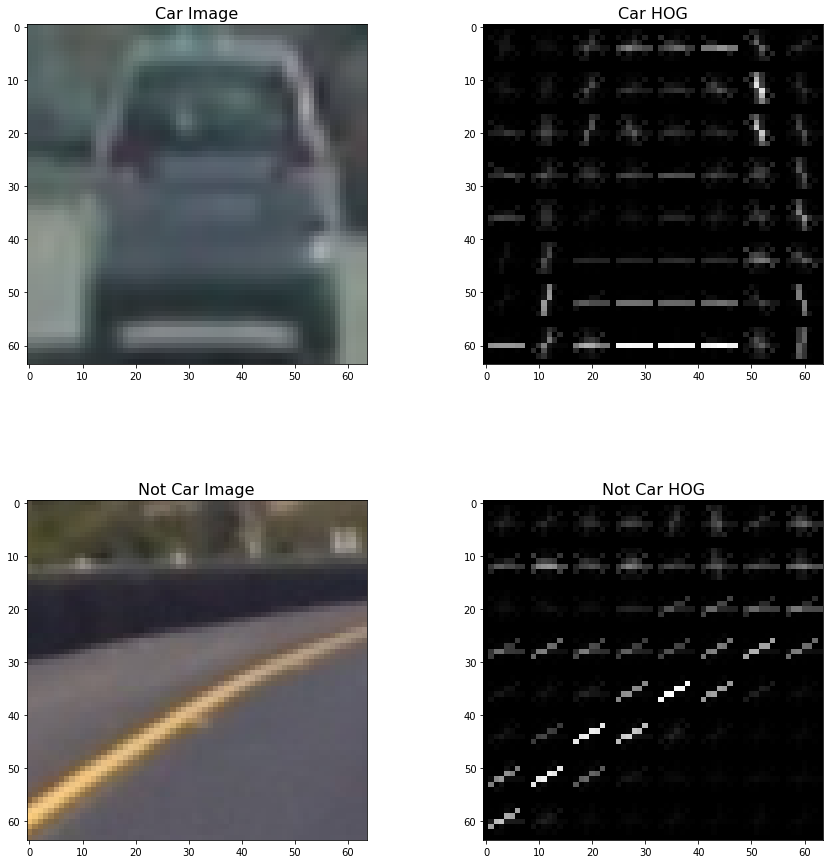

In [5]:
car_img = mpimg.imread(cars[5])
f1, car_dst = get_hog_features(car_img[:,:,2], 9, 8, 2, vis=True, feature_vec=True)
notcar_img = mpimg.imread(notcars[5])
f2, noncar_dst = get_hog_features(notcar_img[:,:,2], 9, 8, 2, vis=True, feature_vec=True)


fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15,15))
fig.subplots_adjust(hspace = .4, wspace=.2)
ax1.imshow(car_img)
ax1.set_title('Car Image', fontsize=16)
ax2.imshow(car_dst, cmap='gray')
ax2.set_title('Car HOG', fontsize=16)
ax3.imshow(notcar_img)
ax3.set_title('Not Car Image', fontsize=16)
ax4.imshow(noncar_dst, cmap='gray')
ax4.set_title('Not Car HOG', fontsize=16)

In [6]:
colorspace = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 11
pix_per_cell = 16
cell_per_block = 2
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"

t = time.time()
car_features = extract_features(cars, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
notcar_features = extract_features(notcars, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract HOG features...')

X = np.vstack((car_features, notcar_features)).astype(np.float64)  


y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))

49.57 Seconds to extract HOG features...
Using: 11 orientations 16 pixels per cell and 2 cells per block
Feature vector length: 1188


In [7]:
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t = time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

1.05 Seconds to train SVC...
Test Accuracy of SVC =  0.9802
My SVC predicts:  [1. 0. 0. 0. 1. 0. 0. 1. 1. 0.]
For these 10 labels:  [1. 0. 0. 0. 1. 0. 0. 1. 1. 0.]
0.01396 Seconds to predict 10 labels with SVC


In [8]:
test_img = mpimg.imread('test_images/test1.jpg')

ystart = 400
ystop = 600
scale = 2.1
colorspace = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 11
pix_per_cell = 16
cell_per_block = 2
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"

dst_img,dst_rectangles = find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, None, orient, pix_per_cell, cell_per_block, None, None)
search_area,_=find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, None, orient, pix_per_cell, cell_per_block, None, None,True)


Image with Vehicle Detection


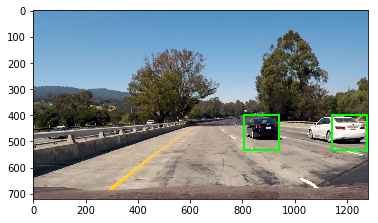

In [9]:
plt.imshow(dst_img)
print('Image with Vehicle Detection')

Search Area


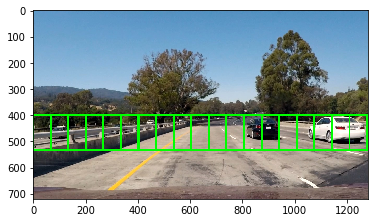

In [10]:
plt.imshow(search_area)
print('Search Area')

In [11]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
 
    imcopy = np.copy(img)
    random_color = False
  
    for bbox in bboxes:
        if color == 'random' or random_color:
            color = (np.random.randint(0,255), np.random.randint(0,255), np.random.randint(0,255))
            random_color = True

        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
  
    return imcopy

In [12]:
box_list=[380,600,1.0],[400,600,2.1],[400,500,1.0],[400,600,1.5]

In [13]:
test_values=[]
test_img=mpimg.imread('test_images/test6.jpg')
copy_img=np.copy(test_img)
for x,y,z in box_list:
        ystart=int(x)
        ystop=int(y)
        scale=z
        colorspace = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
        orient = 11
        pix_per_cell = 16
        cell_per_block = 2
        hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"

        dst_img,dst_rectangles = find_cars(copy_img, ystart, ystop, scale, colorspace, hog_channel, svc, None, orient, pix_per_cell, cell_per_block, None, None)
        test_values.append(dst_rectangles)
        boxes=[item for sublist in test_values for item in sublist]
        img_boxes = draw_boxes(test_img, boxes, (0,255,0), thick=2)

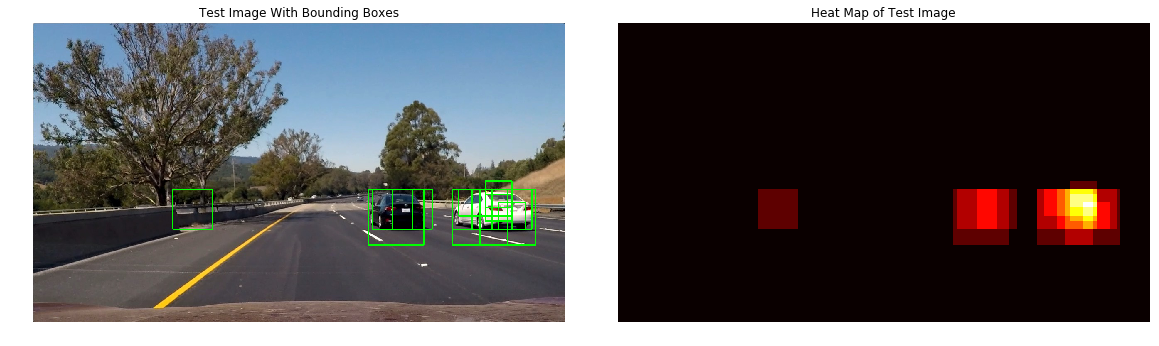

In [14]:
heatmap_img = np.zeros_like(test_img[:,:,0])
heatmap_img_actual = add_heat(heatmap_img, boxes)

fig, axes = plt.subplots(1,2, figsize=(20,20))
fig.subplots_adjust(hspace = 0.0, wspace=0.1)
axes = axes.ravel()
axes[0].axis('off')
axes[1].axis('off')
axes[0].set_title('Test Image With Bounding Boxes')
axes[1].set_title('Heat Map of Test Image')
axes[0].imshow(img_boxes,cmap='hot')
axes[1].imshow(heatmap_img_actual,cmap='hot')


2 Cars Found


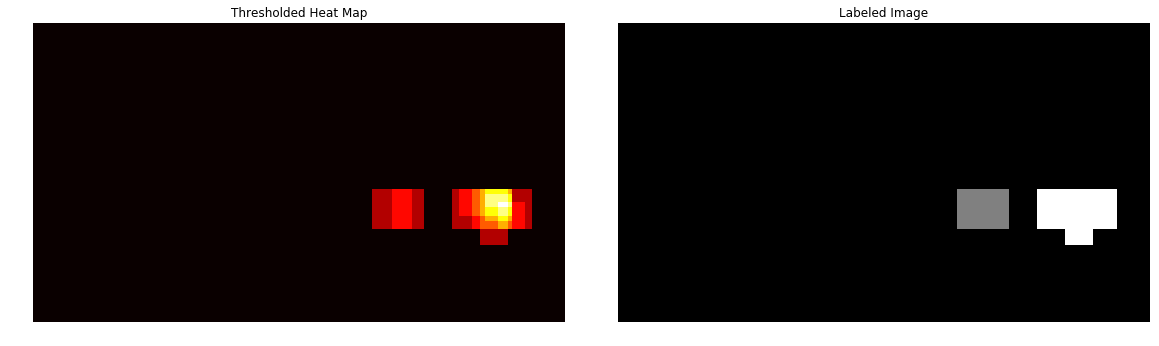

In [15]:
heatmap_img_mod = apply_threshold(heatmap_img_actual,1)
labels = label(heatmap_img_mod)
fig, axes = plt.subplots(1,2, figsize=(20,20))
fig.subplots_adjust(hspace = 0.0, wspace=0.1)
axes = axes.ravel()
axes[0].axis('off')
axes[1].axis('off')
axes[0].set_title('Thresholded Heat Map')
axes[1].set_title('Labeled Image')
axes[0].imshow(heatmap_img_mod,cmap='hot')
axes[1].imshow(labels[0],cmap='gray')
print(str(labels[1])+' Cars Found')

In [16]:
def process_image(img):
    bounds=[]
    for x,y,z in box_list:
        ystart=int(x)
        ystop=int(y)
        scale=z
        colorspace = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
        orient = 11
        pix_per_cell = 16
        cell_per_block = 2
        hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"

        dst_img,dst_rectangles = find_cars(img, ystart, ystop, scale, colorspace, hog_channel, svc, None, orient, pix_per_cell, cell_per_block, None, None)
        bounds.append(dst_rectangles)
        boxes=[item for sublist in bounds for item in sublist]
        heatmap_img = np.zeros_like(img[:,:,0])
        heatmap_img = add_heat(heatmap_img, boxes)
        heatmap_img = apply_threshold(heatmap_img, 1)
        labels = label(heatmap_img)
        draw_img = draw_labeled_bboxes(np.copy(img), labels)
    return draw_img

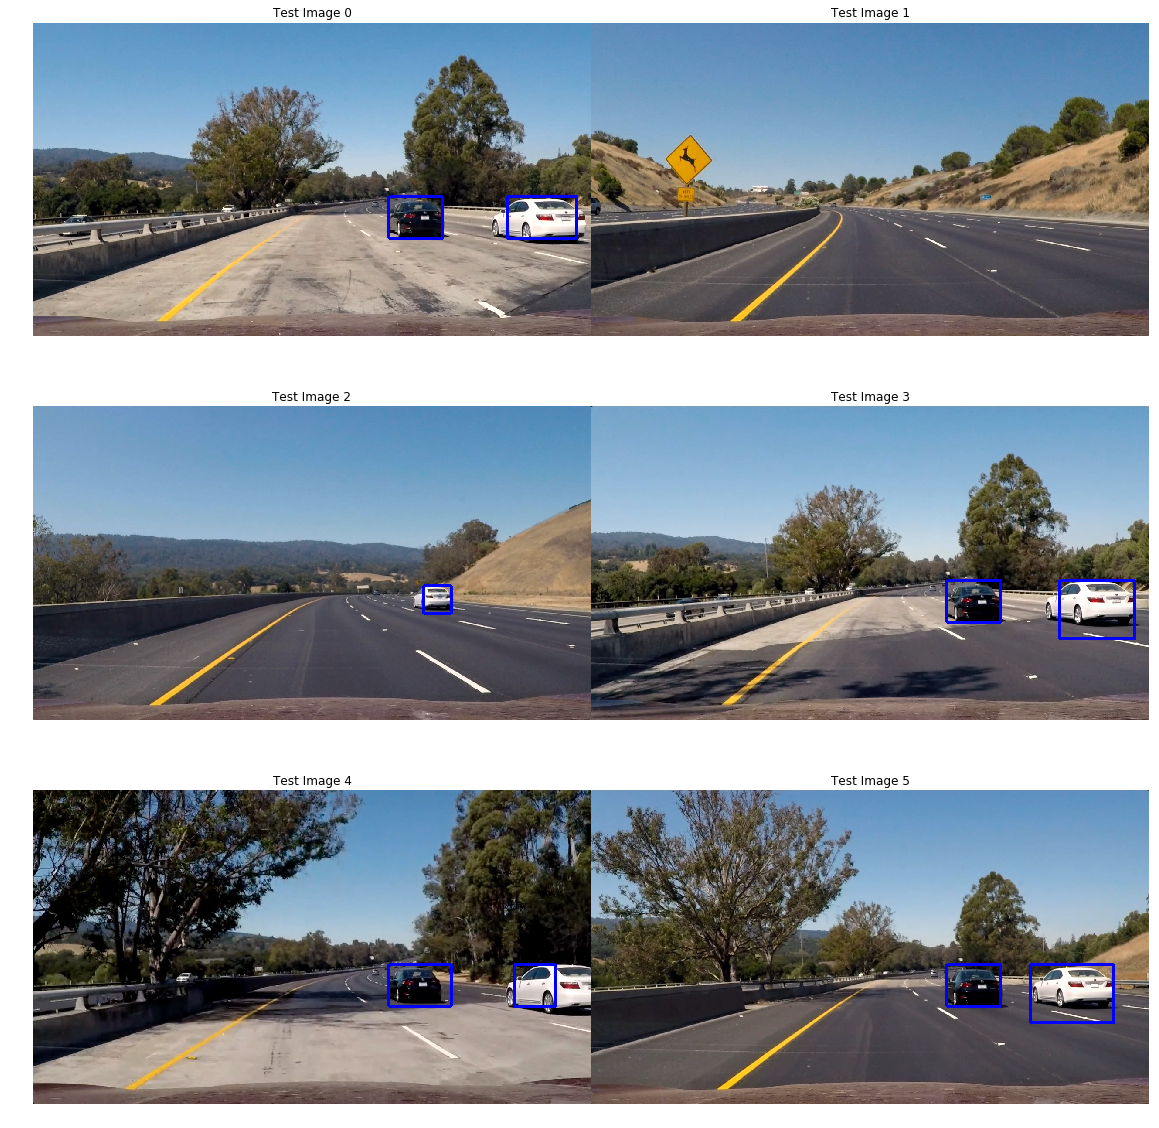

In [24]:
image_list=glob.glob('test_images/*.jpg')
fig, axes = plt.subplots(3,2, figsize=(20,20))
fig.subplots_adjust(hspace = .2, wspace=.001)
axes = axes.ravel()
for i in range(len(image_list)):
    sample_img=mpimg.imread(image_list[i])
    out_img=process_image(sample_img)
    axes[i].axis('off')
    axes[i].set_title('Test Image '+str(i))
    axes[i].imshow(out_img)

In [18]:
class Vehicle_Detect():
    def __init__(self):

        self.prev_boxes = [] 
        
    def add_boxes(self, bboxes):
        self.prev_boxes.append(bboxes)
        if len(self.prev_boxes) > 15:
        
            self.prev_boxes = self.prev_boxes[len(self.prev_boxes)-15:]


In [19]:
def process_video(img):
    bounds=[]
    for x,y,z in box_list:
        ystart=int(x)
        ystop=int(y)
        scale=z
        colorspace = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
        orient = 11
        pix_per_cell = 16
        cell_per_block = 2
        hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"

        dst_img,dst_rectangles = find_cars(img, ystart, ystop, scale, colorspace, hog_channel, svc, None, orient, pix_per_cell, cell_per_block, None, None)
        bounds.append(dst_rectangles)
        boxes=[item for sublist in bounds for item in sublist]
        if len(boxes)>0:
            det.add_boxes(boxes)
        
        heatmap_img = np.zeros_like(img[:,:,0])
        for i in det.prev_boxes:
            
            heatmap_img = add_heat(heatmap_img, i)
        heatmap_img = apply_threshold(heatmap_img, 1+len(det.prev_boxes)//2)
        labels = label(heatmap_img)
        draw_img = draw_labeled_bboxes(np.copy(img), labels)
    return draw_img

In [20]:
det=Vehicle_Detect
test_out_file = 'test_video_out.mp4'
clip_test = VideoFileClip('test_video.mp4')
clip_test_out = clip_test.fl_image(process_image)
%time clip_test_out.write_videofile(test_out_file, audio=False)

[MoviePy] >>>> Building video test_video_out.mp4
[MoviePy] Writing video test_video_out.mp4


 97%|███████████████████████████████████████████████████████████████████████████████▉  | 38/39 [00:14<00:00,  2.50it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_out.mp4 

Wall time: 15 s


In [21]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(test_out_file))

In [22]:
det=Vehicle_Detect()
proj_file_out = 'project_video_out1.mp4'
clip_test = VideoFileClip('project_video1.mp4')
clip_test_out = clip_test.fl_image(process_image)
%time clip_test_out.write_videofile(proj_file_out, audio=False)

[MoviePy] >>>> Building video project_video_out1.mp4
[MoviePy] Writing video project_video_out1.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [07:34<00:00,  2.67it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_out1.mp4 

Wall time: 7min 35s


In [23]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(proj_file_out))